In [1]:
import numpy as np

In [4]:
data = np.load('new_new_data.npy')
print('Shape: ', data.shape)

Shape:  (5, 10, 68, 2)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("landmark_lavar.PNG")
plt.imshow(image)
plt.show()

image = mpimg.imread("lebron_landmark.PNG")
plt.imshow(image)
plt.show()

image = mpimg.imread("bush_landmark.PNG")
plt.imshow(image)
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler, normalize
changed = StandardScaler()
changed.fit(data.reshape(50*68, 2))
new_data = changed.transform(data.reshape(50*68, 2))
normalized = normalize(data.reshape(50, 68, 2).reshape(50*68,2))
standard_normalized = normalize(new_data)

#new_data = new_data.reshape(50, 68, 2).reshape(5, 10, 68, 2)
new_normalized = normalized.reshape(50, 68, 2).reshape(5,10, 68, 2)
standard_normalized = standard_normalized.reshape(50, 68, 2).reshape(5,10, 68, 2)

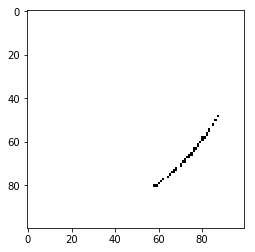

In [26]:
import matplotlib.pyplot as plt

def normPointPlotter(coords):
    img = np.ones((100, 100))
    for x,y in coords.astype(int):
        img[round(y), round(x)] = 0
    plt.imshow(img, cmap = 'gray')
    plt.show()

normPointPlotter(new_normalized[1, 3, :, :]*100 )

In [6]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
input_shape = (136,)
left_input = Input(input_shape, name = 'left')
right_input = Input(input_shape, name = 'right')

convnet = Sequential()
convnet.add(Dense(50,activation="relu"))

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='softmax')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(lr = 0.05)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

6901

In [9]:
ppl = 5
imgs = 10
img_names = []
for i in range(ppl):
    for j in range(imgs):
        img_names.append([i, j])

In [10]:
import itertools
from random import shuffle

ax = [[*p] for p in itertools.product(img_names, repeat=2)]
print(len(ax))
print(ax[0:20])

2500
[[[0, 0], [0, 0]], [[0, 0], [0, 1]], [[0, 0], [0, 2]], [[0, 0], [0, 3]], [[0, 0], [0, 4]], [[0, 0], [0, 5]], [[0, 0], [0, 6]], [[0, 0], [0, 7]], [[0, 0], [0, 8]], [[0, 0], [0, 9]], [[0, 0], [1, 0]], [[0, 0], [1, 1]], [[0, 0], [1, 2]], [[0, 0], [1, 3]], [[0, 0], [1, 4]], [[0, 0], [1, 5]], [[0, 0], [1, 6]], [[0, 0], [1, 7]], [[0, 0], [1, 8]], [[0, 0], [1, 9]]]


In [11]:
from sklearn.cross_validation import train_test_split
x_train, x_test = train_test_split( ax, test_size=0.9)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
def train(data, labels, network, epochs, batch_size):
    track_loss  = defaultdict(list)
    
    for i in range(0, epochs):
        iterations = len(labels)//batch_size
        remain = len(labels)%batch_size
        shuffle(labels)
        avg_loss = 0.0
        for j in range(0, iterations):
            batch = [j*batch_size, j*batch_size + batch_size]
            if(j == iterations - 1):
                batch[1] += remain
            mini_batch = np.zeros(shape = (batch[1] - batch[0], 2, 136))
            for k in range(batch[0], batch[1]):
                student1 = data[labels[k][0][0],labels[k][0][1],:,:]
                student2 = data[labels[k][1][0],labels[k][1][1],:,:]
                student1 -= np.mean(student1)
                student2 -= np.mean(student2)
                mini_batch[k - batch[0]][0] = student1.flatten()
                mini_batch[k - batch[0]][1] = student2.flatten()
            targets = np.array([0 if(labels[i][0][1] == labels[i][1][1]) else 1 for i in range(batch[0], batch[1])])
            new_batch = mini_batch.reshape(batch[1] - batch[0], 2, 136, 1)
            new_targets = targets.reshape(batch[1] - batch[0], 1)
            #print(mini_batch.shape, targets.shape)
            loss=siamese_net.train_on_batch(
            {
             'left': mini_batch[:, 0, :],
             'right': mini_batch[:, 1, :]
            },targets)
            avg_loss += loss
            track_loss['Epoch%s'%(i)].append(loss)
        avg_loss = avg_loss/iterations
        print('Epoch%s-----Loss: %f' %(i + 1, avg_loss))
    return network, track_loss
siamese_net, track_loss = train(data, ax,siamese_net, 50, 10)

Epoch1-----Loss: 1.594239
Epoch2-----Loss: 1.594239
Epoch3-----Loss: 1.594239
Epoch4-----Loss: 1.594239
Epoch5-----Loss: 1.594239
Epoch6-----Loss: 1.594239
Epoch7-----Loss: 1.594239
Epoch8-----Loss: 1.594239
Epoch9-----Loss: 1.594239
Epoch10-----Loss: 1.594239
Epoch11-----Loss: 1.594239
Epoch12-----Loss: 1.594239
Epoch13-----Loss: 1.594239
Epoch14-----Loss: 1.594239
Epoch15-----Loss: 1.594239
Epoch16-----Loss: 1.594239
Epoch17-----Loss: 1.594239
Epoch18-----Loss: 1.594239
Epoch19-----Loss: 1.594239
Epoch20-----Loss: 1.594239
Epoch21-----Loss: 1.594239
Epoch22-----Loss: 1.594239
Epoch23-----Loss: 1.594239
Epoch24-----Loss: 1.594239
Epoch25-----Loss: 1.594239
Epoch26-----Loss: 1.594239
Epoch27-----Loss: 1.594239
Epoch28-----Loss: 1.594239
Epoch29-----Loss: 1.594239
Epoch30-----Loss: 1.594239
Epoch31-----Loss: 1.594239
Epoch32-----Loss: 1.594239
Epoch33-----Loss: 1.594239
Epoch34-----Loss: 1.594239


KeyboardInterrupt: 

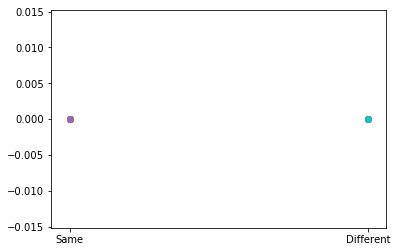

In [35]:
def plotEvalSet(test, actual_data):
    x = np.arange(0, 2)
    for i in range(len(test)):
        person1 = test[i][0]
        person2 = test[i][1]
        same = False
        if(person1[1] == person2[1]):
            same = True
        prepx = actual_data[person1[0],person1[1],:,:]
        prepy = actual_data[person2[0],person2[1],:,:]
        student1 = prepx - np.mean(prepx)
        student2 = prepy - np.mean(prepy)
        student1 = student1.flatten()
        student2 = student2.flatten()
        out = siamese_net.predict({'left': student1.reshape(1, 136),
                                    'right': student2.reshape(1, 136)
                                    })
        if(same):
            plt.scatter(0, out[0][0])
        else:
            plt.scatter(1, out[0][0])
    plt.xticks(x, ['Same', 'Different'])
    plt.show()
            
plotEvalSet(x_test, data)

In [ ]:
from imutils import face_utils
import imutils
import dlib
import cv2

def getFace_Cords(img_name):
    image = cv2.imread(img_name)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    rects = detector(gray, 1)
    shape = predictor(gray, rects[0])
    shape = face_utils.shape_to_np(shape)

    return shape

def computeAbsDifference(coords1, coords2):
    metrics = []
    if(coords1.shape != coords2.shape):
        raise Exception('Coords need to be the same shape')
    for i in range(0,2):
        diff = np.abs(coords1[:, i] - coords2[:, i])
        metrics.append(np.mean(diff))
    return metrics

def getPrediction(net, img1, img2):
    coord1 = getFace_Cords(img1)
    coord2 = getFace_Cords(img2)
    coords1 = coord1 - np.mean(coord1)
    coords2 = coord2 - np.mean(coord2)
    coord1 = coords1.flatten()
    coord2 = coords1.flatten()
    return siamese_net.predict({'left': coord1.reshape(1, 136),
                                'right': coord2.reshape(1, 136)
                                })
     #sum(computeAbsDifference(coords1, coords2))

def getScores(net, combos):
    scores = []
    for i,j in combos:
        scores.append([i[1], j[1], getPrediction(net, 'P%s/img%d.jpg'%(i[0] + 1,i[1] + 1), 'P%s//img%d.jpg'%(j[0] + 1,j[1] + 1))])
    return scores

In [ ]:
predict =getPrediction(siamese_net, 'img21.jpg', 'P1/img1.jpg') #the higher the predict index, the greater the chance of the two 
                                                        #images being similar

In [ ]:
print(predict)

In [ ]:
predict1 = getPrediction(siamese_net, 'P4/img9.jpg', 'P3/img9.jpg')

In [ ]:
print(predict1)

In [ ]:
predict2 = getPrediction(siamese_net, 'img22.jpg', 'P3/img9.jpg')

In [ ]:
print(predict2)

In [ ]:
siamese_net.save_weights('my_model_weights.h5')